In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
%matplotlib inline
import seaborn as sns

from ipywidgets import IntProgress
from IPython.display import display

from os import listdir, path
from math import floor

import numpy as np
import random

# set random seeds to aid reproducibility
random.seed(22)
np.random.seed(22)

from skimage import io, color
from skimage.transform import resize

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn import svm, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [11]:
malaria_dataset_path = 'cell_images/'
parasitized_dir = 'Parasitized'
uninfected_dir = 'Uninfected'
default_ext = '.npy'

def initialize_progress_bar(max_count):

    f = IntProgress(min=0, max=max_count)
    display(f)
    f.value = 0
    return f

def save_data(data, save_file_path, data_type='float32'):

    print('Saving file {0}...'.format(save_file_path))
    data = data.astype(data_type)
    np.save(save_file_path, data, allow_pickle=False, fix_imports=False)
    print('Done.')
    return data

def load_data(file_path):

    data = np.load(file_path)
    return data

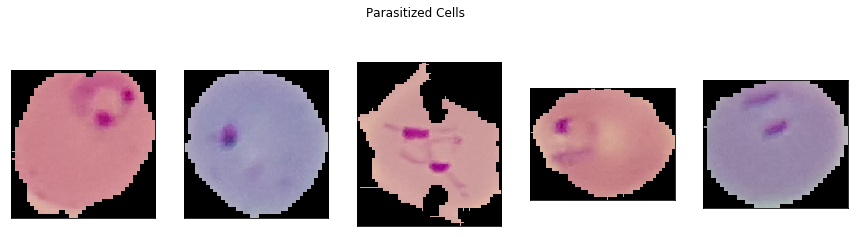

In [12]:
def show_sample_cells(cell_type, num_cells=5, greyscale=False, resize_image=False):
    fig, axes = plt.subplots(1, num_cells, figsize=(15,4))
    fig.suptitle('{0} Cells{1}{2}'.format(cell_type, 
                                          ' - Greyscale' if greyscale else '',
                                          ' - 50x50' if resize_image else ''))
    for idx, f in enumerate(listdir(path.join(malaria_dataset_path, cell_type))[:5]):
        cell_image = io.imread(path.join(malaria_dataset_path, cell_type, f))
        if resize_image:
            cell_image = resize(cell_image, (50, 50, cell_image.shape[2]), mode='reflect')
        if greyscale:
            cell_image = color.rgb2grey(cell_image)
            axes[idx].imshow(cell_image, cmap='gray')
        else:
            axes[idx].imshow(cell_image)
        axes[idx].set_xticks([])
        axes[idx].set_yticks([])
        
show_sample_cells(parasitized_dir)

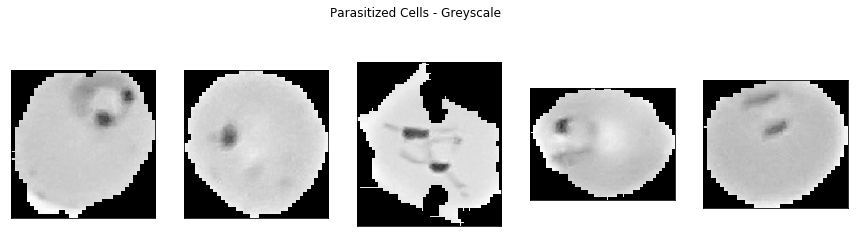

In [13]:
show_sample_cells(parasitized_dir, greyscale=True)

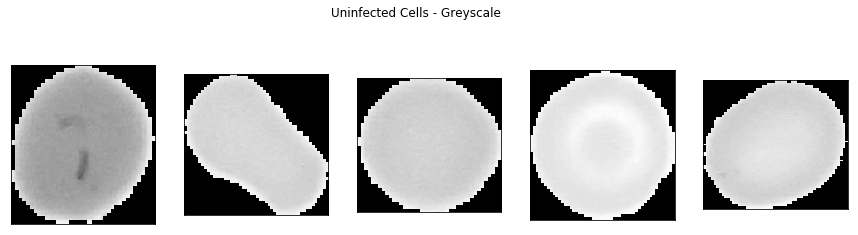

In [14]:
show_sample_cells(uninfected_dir, greyscale=True)

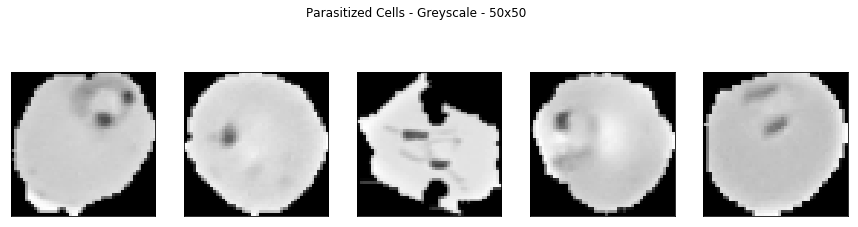

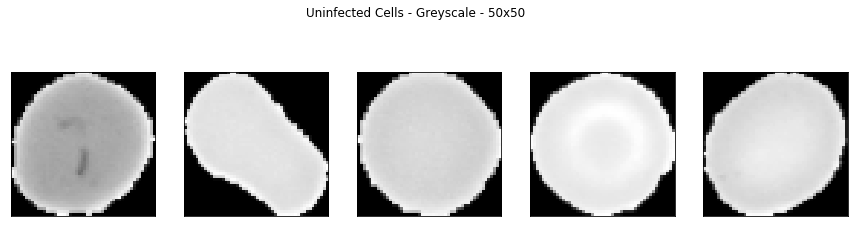

In [15]:
show_sample_cells(parasitized_dir, greyscale=True, resize_image=True)
show_sample_cells(uninfected_dir, greyscale=True, resize_image=True)

In [26]:
def resize_cell_images(cell_images_path):
    cell_image_files = listdir(cell_images_path)
    cell_image_files = [f for f in cell_image_files if f.endswith('.png')]
    cell_image_files.sort()
    
    num_cell_images = len(cell_image_files)
    f = initialize_progress_bar(num_cell_images)
    data = np.zeros((num_cell_images,50,50,3))
    for idx, cell_image_file in enumerate(cell_image_files):
        cell_image = io.imread(path.join(cell_images_path, cell_image_file))
        cell_image_resized = resize(cell_image, (50, 50, cell_image.shape[2]), mode='reflect')
        data[idx] = cell_image_resized
        f.value += 1
    data = data.astype('float32')
    return data

def greyscale_cell_images(data):
    f = initialize_progress_bar(data.shape[0])
    gs_data = np.zeros((data.shape[0],50,50))
    for idx, cell_image in enumerate(data):
        gs_data[idx] = color.rgb2grey(cell_image)
        f.value += 1
    gs_data = gs_data.astype('float32')
    return gs_data

def histnorm_cell_images(data):
    f = initialize_progress_bar(data.shape[0])
    hn_data = np.zeros((data.shape[0],10))
    for idx, cell_image in enumerate(data):
        # range starts from 0.1 to eliminate all black background, value 0
        counts, bins = np.histogram(cell_image, bins=10, range=(0.1,1))
        hn_data[idx] = counts / np.sum(counts)
        f.value += 1
    hn_data = hn_data.astype('float32')
    return hn_data

def load_histnorm_data(cell_types):    
    print('Loading {0}...'.format(cell_types))
    
    histnorm_data_file_path = path.join(malaria_dataset_path, ''.join(['hn_', cell_types, default_ext]))
    if path.isfile(histnorm_data_file_path):
        print('Loading histnorm data...')
        histnorm_data = load_data(histnorm_data_file_path)
    else:
        greyscaled_cell_images_data_file_path = path.join(malaria_dataset_path, ''.join(['gs_', cell_types, default_ext]))
        if path.isfile(greyscaled_cell_images_data_file_path):
            print('Loading greyscaled cell images...')
            greyscaled_cell_images_data = load_data(greyscaled_cell_images_data_file_path)
        else:
            resized_cell_images_data_file_path = path.join(malaria_dataset_path, ''.join(['rs_', cell_types, default_ext]))
            if path.isfile(resized_cell_images_data_file_path):
                print('Loading resized cell images...')
                resized_cell_images_data = load_data(resized_cell_images_data_file_path)
            else:
                print('Resizing cell images...')
                resized_cell_images_data = resize_cell_images(path.join(malaria_dataset_path, cell_types))
                resized_cell_images_data = save_data(resized_cell_images_data, resized_cell_images_data_file_path)
                
            print('Greyscaling cell images...')
            greyscaled_cell_images_data = greyscale_cell_images(resized_cell_images_data)
            greyscaled_cell_images_data = save_data(greyscaled_cell_images_data, greyscaled_cell_images_data_file_path)
            
        print('Histnorming cell images...')
        histnorm_data = histnorm_cell_images(greyscaled_cell_images_data)
        histnorm_data = save_data(histnorm_data, histnorm_data_file_path)
        
    return histnorm_data

In [27]:
def plot_data_scatter(parasitized_data, uninfected_data):
    if (
         parasitized_data.shape[1] >= 2 and
         uninfected_data.shape[1] >= 2
       ):
        # plot top two components
        plt.scatter(parasitized_data[:,0],
                    parasitized_data[:,1],
                    color='navy',
                    alpha=0.5,
                    label='Parasitized')
        plt.scatter(uninfected_data[:,0],
                    uninfected_data[:,1],
                    color='darkorange',
                    alpha=0.5,
                    label='Uninfected')
        plt.legend()

    if (
         parasitized_data.shape[1] >= 3 and
         uninfected_data.shape[1] >= 3
       ):
        # plot top three components
        fig = plt.figure(figsize=(9,5))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(parasitized_data[:,0],
                   parasitized_data[:,1],
                   parasitized_data[:,2],
                   color='navy',
                   alpha=0.5,
                   label='Parasitized')
        ax.scatter(uninfected_data[:,0],
                   uninfected_data[:,1],
                   uninfected_data[:,2],
                   color='darkorange',
                   alpha=0.5,
                   label='Uninfected')
        ax.legend()
        
    plt.show()

Loading Parasitized...
Resizing cell images...


IntProgress(value=0, max=13625)

Saving file cell_images/rs_Parasitized.npy...
Done.
Greyscaling cell images...


IntProgress(value=0, max=13625)

Saving file cell_images/gs_Parasitized.npy...
Done.
Histnorming cell images...


IntProgress(value=0, max=13625)

Saving file cell_images/hn_Parasitized.npy...
Done.
Loading Uninfected...
Resizing cell images...


IntProgress(value=0, max=13625)

Saving file cell_images/rs_Uninfected.npy...
Done.
Greyscaling cell images...


IntProgress(value=0, max=13625)

Done.
Histnorming cell images...


IntProgress(value=0, max=13625)

Saving file cell_images/hn_Uninfected.npy...
Done.


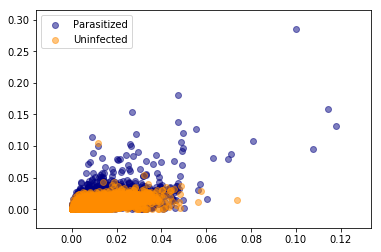

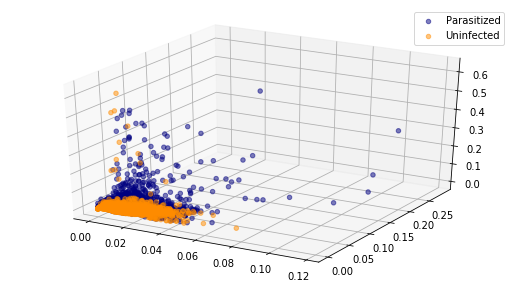

CPU times: user 6min 34s, sys: 1min 1s, total: 7min 35s
Wall time: 6min 32s


In [28]:
%%time
parasitized_histnorm_data = load_histnorm_data(parasitized_dir)
uninfected_histnorm_data = load_histnorm_data(uninfected_dir)
plot_data_scatter(parasitized_histnorm_data, uninfected_histnorm_data)


In [29]:
def _add_class(data, positive_class=False):    
    if positive_class:
        new_data = np.ones((data.shape[0], data.shape[1]+1))
    else:
        new_data = np.zeros((data.shape[0], data.shape[1]+1))
    new_data[:,:-1] = data[:,:]
    return new_data

def _create_training_testing_split(parasitized_class_data, uninfected_class_data, training=0.8):
    '''
        training: default to 80% of data
        testing: remaining data
    '''
    
    # equal count of parasitized and uninfected records in the malaria dataset
    parasitized_class_data.shape[0] == uninfected_class_data.shape[0]
    
    num_samples_in_each_class = parasitized_class_data.shape[0]
    num_features_plus_class = parasitized_class_data.shape[1]
    
    print('{0} samples in each class with {1} features.'.format(num_samples_in_each_class,
                                                                num_features_plus_class-1))
    
    training_count = floor(num_samples_in_each_class * training)
    testing_count = num_samples_in_each_class - training_count
    
    print('Splitting into {0} training and {1} testing samples.'.format(training_count,
                                                                        testing_count))
    
    # Create random training / testing index masks for parasitized / uninfected data
    # so as to split data randomly into training and testing sets.
    parasitized_testing_indices = random.sample(range(0, num_samples_in_each_class), testing_count)
    parasitized_training_mask = np.ones(num_samples_in_each_class, dtype=bool)
    parasitized_training_mask[parasitized_testing_indices] = False
    uninfected_testing_indices = random.sample(range(0, num_samples_in_each_class), testing_count)
    uninfected_training_mask = np.ones(num_samples_in_each_class, dtype=bool)
    uninfected_training_mask[uninfected_testing_indices] = False
    
    # creating training data set
    training_data = np.zeros((training_count*2, num_features_plus_class))
    training_data[:training_count,:] = parasitized_class_data[parasitized_training_mask]
    training_data[training_count:,:] = uninfected_class_data[uninfected_training_mask]
    
    testing_data = np.zeros((testing_count*2, num_features_plus_class))
    testing_data[:testing_count,:] = parasitized_class_data[~parasitized_training_mask]
    testing_data[testing_count:,:] = uninfected_class_data[~uninfected_training_mask]
    
    # shuffle rows
    np.random.shuffle(training_data)
    np.random.shuffle(testing_data)
    
    return training_data, testing_data

def _create_training_testing_data():
    print('Creating training and testing data files...')
        
    print('Loading histnormed data...')
    parasitized_histnorm_data = load_histnorm_data(parasitized_dir)
    uninfected_histnorm_data = load_histnorm_data(uninfected_dir)

    print('Extracting features from data...')
    parasitized_class_data = _add_class(parasitized_histnorm_data, positive_class=True)
    uninfected_class_data = _add_class(uninfected_histnorm_data)

    print('Splitting data into training and testing data sets...')
    training_data, testing_data = _create_training_testing_split(parasitized_class_data,
                                                                 uninfected_class_data)
    
    assert np.sum(training_data[:,-1:]) == len(training_data)/2, "Training data is not balanced."
    assert np.sum(testing_data[:,-1:]) == len(testing_data)/2, "Testing data is not balanced."
    
    print('Done.')
    
    return training_data, testing_data
    
def load_datasets():
    training_file_path = path.join(malaria_dataset_path, ''.join(['training', default_ext]))
    testing_file_path = path.join(malaria_dataset_path, ''.join(['testing', default_ext]))
    
    if path.isfile(training_file_path) and path.isfile(testing_file_path):
        print('Loading training and testing data...')
        training_data = load_data(training_file_path)
        testing_data = load_data(testing_file_path)
        print('Done.')
    else:
        training_data, testing_data = _create_training_testing_data()
        
        print('Saving training and testing data sets...')
        training_data = save_data(training_data, training_file_path)
        testing_data = save_data(testing_data, testing_file_path)
        print('Done.')
        
    X_train = training_data[:,:-1]
    y_train = training_data[:,-1:]
    y_train = y_train.reshape([y_train.shape[0],])
    X_test = testing_data[:,:-1]
    y_test = testing_data[:,-1:]
    y_test = y_test.reshape([y_test.shape[0],])
        
    return X_train, y_train, X_test, y_test

In [30]:
X_train, y_train, X_test, y_test = load_datasets()

Creating training and testing data files...
Loading histnormed data...
Loading Parasitized...
Loading histnorm data...
Loading Uninfected...
Loading histnorm data...
Extracting features from data...
Splitting data into training and testing data sets...
13625 samples in each class with 10 features.
Splitting into 10900 training and 2725 testing samples.
Done.
Saving training and testing data sets...
Saving file cell_images/training.npy...
Done.
Saving file cell_images/testing.npy...
Done.
Done.


Loading training and testing data...
Done.


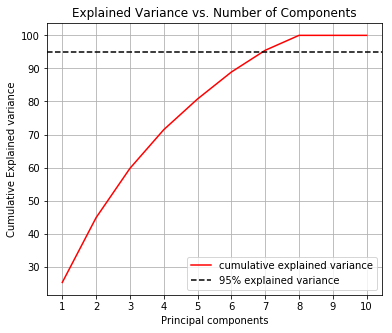

In [31]:
X_train, y_train, X_test, y_test = load_datasets()
scaler = StandardScaler()
scaler.fit(X_train)
X_train_stand = scaler.transform(X_train)

pca = PCA()
pca.fit(X_train_stand)
cum_exp_var = pca.explained_variance_ratio_.cumsum()*100
d = [n for n in range(1, len(cum_exp_var)+1)]
plt.figure(figsize=(6, 5))
plt.xticks(d)
plt.grid(True, which='both')
plt.plot(d, cum_exp_var, color = 'red',label='cumulative explained variance')
plt.title('Explained Variance vs. Number of Components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axhline(y = 95, color='k', linestyle='--', label = '95% explained variance')
plt.legend(loc='best')
plt.show()

# SVM

In [57]:
X_train, y_train, X_test, y_test = load_datasets()

scaler = StandardScaler()
scaler.fit(X_train)
X_train_stand = scaler.transform(X_train)
X_test_stand = scaler.transform(X_test)

pca = PCA(n_components=7)
pca.fit(X_train_stand)
pca_X_train = pca.transform(X_train_stand)
pca_X_test = pca.transform(X_test_stand)

clf = svm.SVC(kernel='rbf', gamma=1, C=100)
clf.fit(pca_X_train, y_train)

Loading training and testing data...
Done.


SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [58]:
predictions_svm = clf.predict(pca_X_test)

Accuracy: 0.813
Matthews CC: 0.627
F1 Score: 0.809
Sensitivity: 0.793
Specificity: 0.826


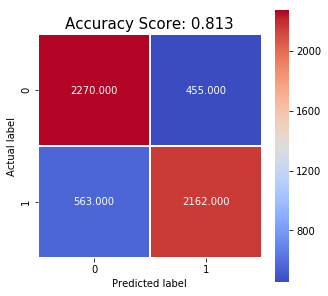

In [63]:
confusion_matrix = metrics.confusion_matrix(y_test, predictions_svm)
TP, FP, FN, TN = confusion_matrix.ravel()

specificity = TN / (TN + FP) # True Negative Rate

plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = plt.cm.coolwarm);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0:.3f}'.format(metrics.accuracy_score(y_test, predictions_svm))
plt.title(all_sample_title, size = 15);

print('Accuracy: {0:.3f}'.format(metrics.accuracy_score(y_test, predictions_svm)))
print('Matthews CC: {0:.3f}'.format(metrics.matthews_corrcoef(y_test, predictions_svm)))
print('F1 Score: {0:.3f}'.format(metrics.f1_score(y_test, predictions_svm)))
print('Sensitivity: {0:.3f}'.format(metrics.recall_score(y_test, predictions_svm)))
print('Specificity: {0:.3f}'.format(specificity))


In [60]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr_keras, tpr_keras, thresholds = roc_curve(y_test.ravel(), predictions_svm.ravel())
auc_keras = auc(fpr_keras, tpr_keras)




In [61]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()



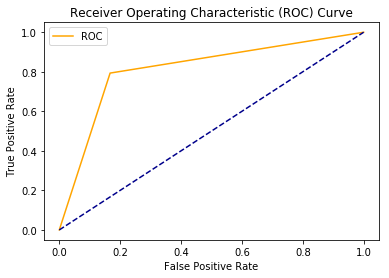

In [62]:
plot_roc_curve(fpr_keras, tpr_keras)

# KNN

In [44]:
X_train, y_train, X_test, y_test = load_datasets()

scaler = StandardScaler()
scaler.fit(X_train)
X_train_stand = scaler.transform(X_train)
X_test_stand = scaler.transform(X_test)

pca = PCA(n_components=7)
pca.fit(X_train_stand)
pca_X_train = pca.transform(X_train_stand)
pca_X_test = pca.transform(X_test_stand)

b = KNeighborsClassifier(n_neighbors = 2).fit(X_train,y_train) # Fitting the model.


Loading training and testing data...
Done.


In [46]:
predictions_knn = b.predict(X_test) # Test set is predicted.
print(accuracy_score(y_test,predictions)) # Accuracy score is calculated.
print(classification_report(y_test,predictions)) # Classification report is generated.

0.7788990825688074
              precision    recall  f1-score   support

         0.0       0.73      0.89      0.80      2725
         1.0       0.86      0.67      0.75      2725

    accuracy                           0.78      5450
   macro avg       0.79      0.78      0.78      5450
weighted avg       0.79      0.78      0.78      5450



Accuracy: 0.779
Matthews CC: 0.572
F1 Score: 0.752
Sensitivity: 0.670
Specificity: 0.857


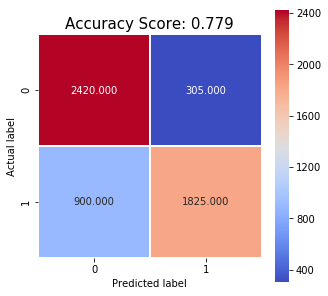

In [47]:
confusion_matrix = metrics.confusion_matrix(y_test, predictions_knn)
TP, FP, FN, TN = confusion_matrix.ravel()

specificity = TN / (TN + FP) # True Negative Rate

plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = plt.cm.coolwarm);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0:.3f}'.format(metrics.accuracy_score(y_test, predictions))
plt.title(all_sample_title, size = 15);

print('Accuracy: {0:.3f}'.format(metrics.accuracy_score(y_test, predictions_knn)))
print('Matthews CC: {0:.3f}'.format(metrics.matthews_corrcoef(y_test, predictions_knn)))
print('F1 Score: {0:.3f}'.format(metrics.f1_score(y_test, predictions_knn)))
print('Sensitivity: {0:.3f}'.format(metrics.recall_score(y_test, predictions_knn)))
print('Specificity: {0:.3f}'.format(specificity))

In [51]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr_keras, tpr_keras, thresholds = roc_curve(y_test.ravel(), predictions_knn.ravel())
auc_keras = auc(fpr_keras, tpr_keras)



In [52]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()


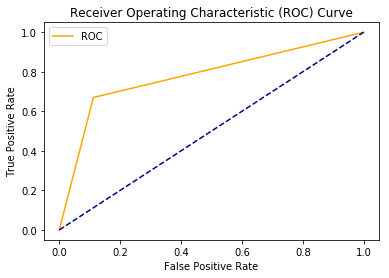

In [53]:
plot_roc_curve(fpr_keras, tpr_keras)